In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import math

from sklearn import tree
from sklearn.model_selection import train_test_split

get_ipython().magic(u'matplotlib inline') #para imprimir no próprio notebook

%matplotlib inline
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from __future__ import print_function


from sklearn.model_selection import train_test_split
from sklearn import tree

In [2]:
#Funções auxiliares
def plot_correlation_map( df, figsize = (12,10)):
    corr = df.corr().round(2)
    _ , ax = plt.subplots(figsize = figsize)
    cmap = sns.diverging_palette(220,10, as_cmap=True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax, 
        annot=True, 
        annot_kws={'fontsize':12}
    )
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df,row = row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [3]:
#Adaptado de https://www.kaggle.com/sachinkulkarni/titanic/an-interactive-data-science-tutorial
#carrega a base de dados
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
full = train.append(test , ignore_index = True)
print("Datasets:\nCompleto: " , full.shape, "\nTreinamento:", train.shape,"\nTeste:",test.shape)

Datasets:
Completo:  (1309, 12) 
Treinamento: (891, 12) 
Teste: (418, 11)


In [4]:
#Identifica as características presentes
train.columns.values

#Descrição das variáveis
#We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:
#Variable Description
#Survived: Survived (1) or died (0)
#Pclass: Passenger's class
#Name: Passenger's name
#Sex: Passenger's sex
#Age: Passenger's age
#SibSp: Number of siblings/spouses aboard
#Parch: Number of parents/children aboard
#Ticket: Ticket number
#Fare: Fare
#Cabin: Cabin
#Embarked: Port of embarkation

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [5]:
#Análise dos dados. Observe que é possível identificar dados inconsistentes. Por exemplo, idade mínima de 0.42!
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


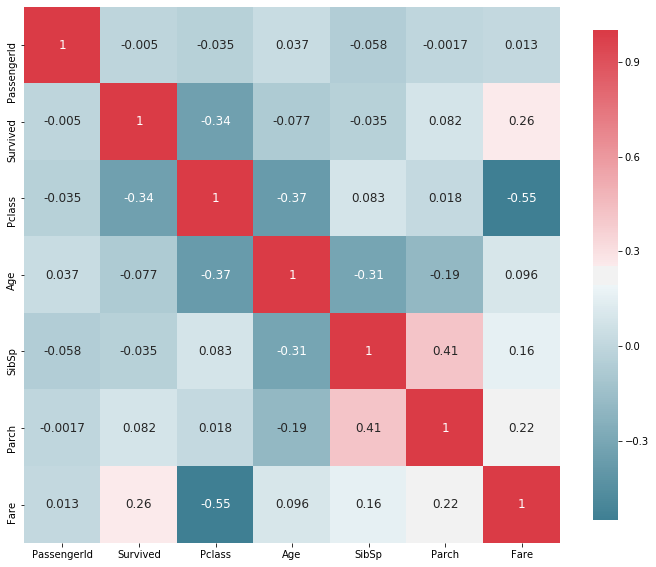

In [6]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(train)

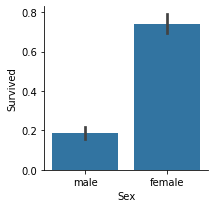

In [7]:
#Distribuição das amostras dentro de uma mesma classe
#Visualize a "Survival Rate" em relação aos seguintes atributos: Embarked, Sex, Pclass, SibSp, Parch
plot_categories(train, cat = 'Sex', target = 'Survived')

# Ajustando os dados

### Novas colunas

In [8]:
#Altera o atributo "Sex" de valores nominais (Male/Female)para 0 e 1
full["Male"] = (full.Sex == "male").astype(int)
full = full.drop(['Sex'],axis=1)
full.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,SibSp,Survived,Ticket,Male
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,0.0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1.0,PC 17599,0


In [9]:
#Cria uma nova variável para cada valor único de "Embarked" (no caso, Embarked_C  Embarked_Q  Embarked_S)
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')
#Cria uma nova variável para cada valor único de "Pclass"
pclass = pd.get_dummies(full.Pclass , prefix='Pclass' )

print(embarked.sum())
print(pclass.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,embarked,pclass],axis=1)
full = full.drop(['Embarked','Pclass'],axis=1)
full.head(2)

Embarked_C    270
Embarked_Q    123
Embarked_S    914
dtype: int64
Pclass_1    323
Pclass_2    277
Pclass_3    709
dtype: int64


,Age,Cabin,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,1,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,0,1,0,0,1,0,0


In [10]:
#As distinções refletiam o status social e podem ser utilziados para prever a probabilidade de sobrevivência

title = pd.DataFrame()

#Extrai o título de cada nome
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

#Lista agregada de títulos
Title_Dictionary = {
                    "Capt":       "Officer_Royalty",#Officer
                    "Col":        "Officer_Royalty",#Officer
                    "Major":      "Officer_Royalty",#Officer
                    "Jonkheer":   "Officer_Royalty",#Royalty
                    "Don":        "Officer_Royalty",#Royalty
                    "Sir" :       "Officer_Royalty",#Royalty
                    "Dr":         "Officer_Royalty",#Officer
                    "Rev":        "Officer_Royalty",#Officer
                    "the Countess":"Officer_Royalty",#Royalty
                    "Dona":       "Officer_Royalty",#Royalty
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Officer_Royalty"#Royalty
                    }

#Faz o mapeamento de cada título
title['Title'] = title.Title.map(Title_Dictionary)
#Cria uma nova variável para cada título
title = pd.get_dummies(title.Title)

print(title.sum())

#junta novas colunas 
full = pd.concat([full,title],axis=1)
full = full.drop(['Name'],axis=1)
full.head(2)

Master              61
Miss               262
Mr                 757
Mrs                200
Officer_Royalty     29
dtype: int64


,Age,Cabin,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer_Royalty
0,22.0,NaN,7.2500,0,1,1,0.0,A/5 21171,1,0,0,1,0,0,1,0,0,1,0,0
1,38.0,C85,71.2833,0,2,1,1.0,PC 17599,0,1,0,0,1,0,0,0,0,0,1,0


In [11]:
#Extrai a categoria da cabine a partir do número
cabin = pd.DataFrame()

#Substitui dados faltantes por "U" (Uknown)
cabin['Cabin'] = full.Cabin.fillna( 'U' )

#Mapeia cada valor de cabine com a letra
cabin['Cabin'] = cabin['Cabin'].map(lambda c : c[0])

#Cria uma variável para cada categoria
cabin = pd.get_dummies(cabin['Cabin'] , prefix = 'Cabin')

print(cabin.sum())
#junta pois tem poucos dados 
cabin['Cabin_AB'] = cabin['Cabin_A']+cabin['Cabin_B']
cabin['Cabin_DE'] = cabin['Cabin_D']+cabin['Cabin_E']
cabin['Cabin_FGT'] = cabin['Cabin_F']+cabin['Cabin_G']+cabin['Cabin_T']
cabin = cabin.drop(["Cabin_A","Cabin_B","Cabin_D","Cabin_E","Cabin_F","Cabin_G","Cabin_T"],axis=1)

print(cabin.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,cabin],axis=1)
full = full.drop(['Cabin'],axis=1)

full.head(2)

Cabin_A      22
Cabin_B      65
Cabin_C      94
Cabin_D      46
Cabin_E      41
Cabin_F      21
Cabin_G       5
Cabin_T       1
Cabin_U    1014
dtype: int64
Cabin_C        94
Cabin_U      1014
Cabin_AB       87
Cabin_DE       87
Cabin_FGT      27
dtype: int64


,Age,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,...,Master,Miss,Mr,Mrs,Officer_Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FGT
0,22.0,7.2500,0,1,1,0.0,A/5 21171,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,38.0,71.2833,0,2,1,1.0,PC 17599,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [12]:
''' 
#Removido por possuir poucas amostras por cada classe
#Extrai a classe de cada ticket a partir do seu número
#Caso não tenha prefixo, retorna XXX
def cleanTicket( ticket ):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

#Cria uma nova variável para cada caso
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )
print(ticket.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,family],axis=1)
'''
full = full.drop(['Ticket'],axis=1)
#full.head(2)

In [13]:
'''
#Cria variáveis para representar o tamanho da família e também cada categoria
family = pd.DataFrame()

#Cria nova característica que representa o tamanho da família (quantidade de membros)
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1

#Cria nova características para representar o tipo de família 
family['Family_Single'] = family['FamilySize'].map(lambda s : 1 if s == 1 else 0)
#family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 4 else 0)
#family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 5 <= s else 0)
family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 3 else 0)
family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 4 <= s else 0)
print(family.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,family],axis=1)
full = full.drop(['FamilySize'],axis=1)

full.head(2)
'''
print()

In [14]:
full = full.drop(["PassengerId"],axis=1)
full.shape

(1309, 22)

### Missing Values

In [15]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 22 columns):
Age                1046 non-null float64
Fare               1308 non-null float64
Parch              1309 non-null int64
SibSp              1309 non-null int64
Survived           891 non-null float64
Male               1309 non-null int64
Embarked_C         1309 non-null uint8
Embarked_Q         1309 non-null uint8
Embarked_S         1309 non-null uint8
Pclass_1           1309 non-null uint8
Pclass_2           1309 non-null uint8
Pclass_3           1309 non-null uint8
Master             1309 non-null uint8
Miss               1309 non-null uint8
Mr                 1309 non-null uint8
Mrs                1309 non-null uint8
Officer_Royalty    1309 non-null uint8
Cabin_C            1309 non-null uint8
Cabin_U            1309 non-null uint8
Cabin_AB           1309 non-null uint8
Cabin_DE           1309 non-null uint8
Cabin_FGT          1309 non-null uint8
dtypes: float64(3), int64(3), 

In [16]:
#Muitos algoritmos requerem que todas as amostras possuam valores atribuídos para todas as características. 
#No caso de dados faltantes, uma possibilidade é preenchê-los com o valor médio das demais observações.

#Preenche os valores que faltam em "Age" com a média das demais idades
full['Age'] = full.Age.fillna(full.Age.mean())

#O mesmo para "Fare"
full['Fare'] = full.Fare.fillna(full.Fare.mean())

full.head(2)

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Master,Miss,Mr,Mrs,Officer_Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FGT
0,22.0,7.2500,0,1,0.0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,38.0,71.2833,0,1,1.0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0


In [17]:
#Seleciona as características que serão incluídas no descritor (vetor de características)
#full_all = pd.concat([imputed, embarked, family, sex, title, full.Survived] , axis=1)
#full_all.head()

# Visualisation 2

In [48]:
full = full2.copy()

In [49]:
#separa novamente dados de traino e test
survived = full['Survived'][:train.shape[0]]
full = full.drop(['Survived'],axis=1)
train = full[:train.shape[0]]
test = full[train.shape[0]:]
train['Survived'] = survived

train.shape,test.shape

((891, 22), (418, 21))

In [50]:
#Análise dos dados. Observe que é possível identificar dados inconsistentes. Por exemplo, idade mínima de 0.42!
train.describe()

,Age,Fare,Parch,SibSp,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,...,Miss,Mr,Mrs,Officer_Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FGT,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.735277,32.204208,0.381594,0.523008,0.647587,0.188552,0.086420,0.722783,0.242424,0.206510,...,0.206510,0.580247,0.142536,0.025814,0.066218,0.771044,0.069585,0.072952,0.020202,0.383838
std,13.002218,49.693429,0.806057,1.102743,0.477990,0.391372,0.281141,0.447876,0.428790,0.405028,...,0.405028,0.493796,0.349796,0.158668,0.248802,0.420397,0.254589,0.260203,0.140770,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,29.881138,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,31.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,80.000000,512.329200,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


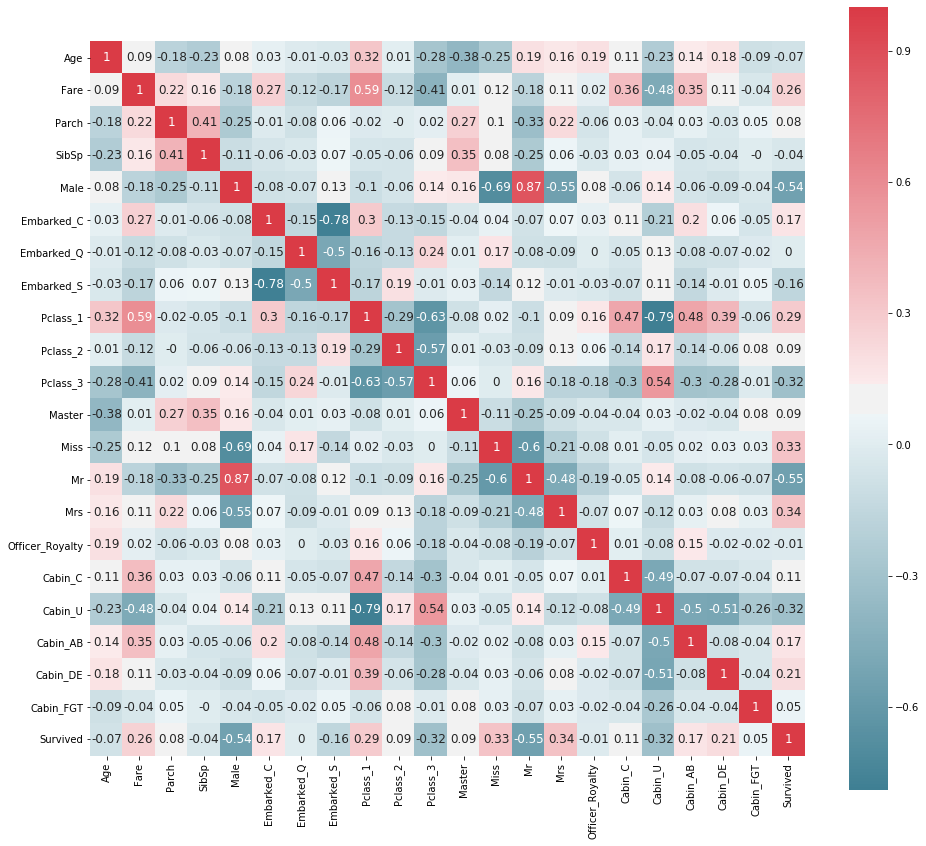

In [51]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(train,figsize=(16,16))

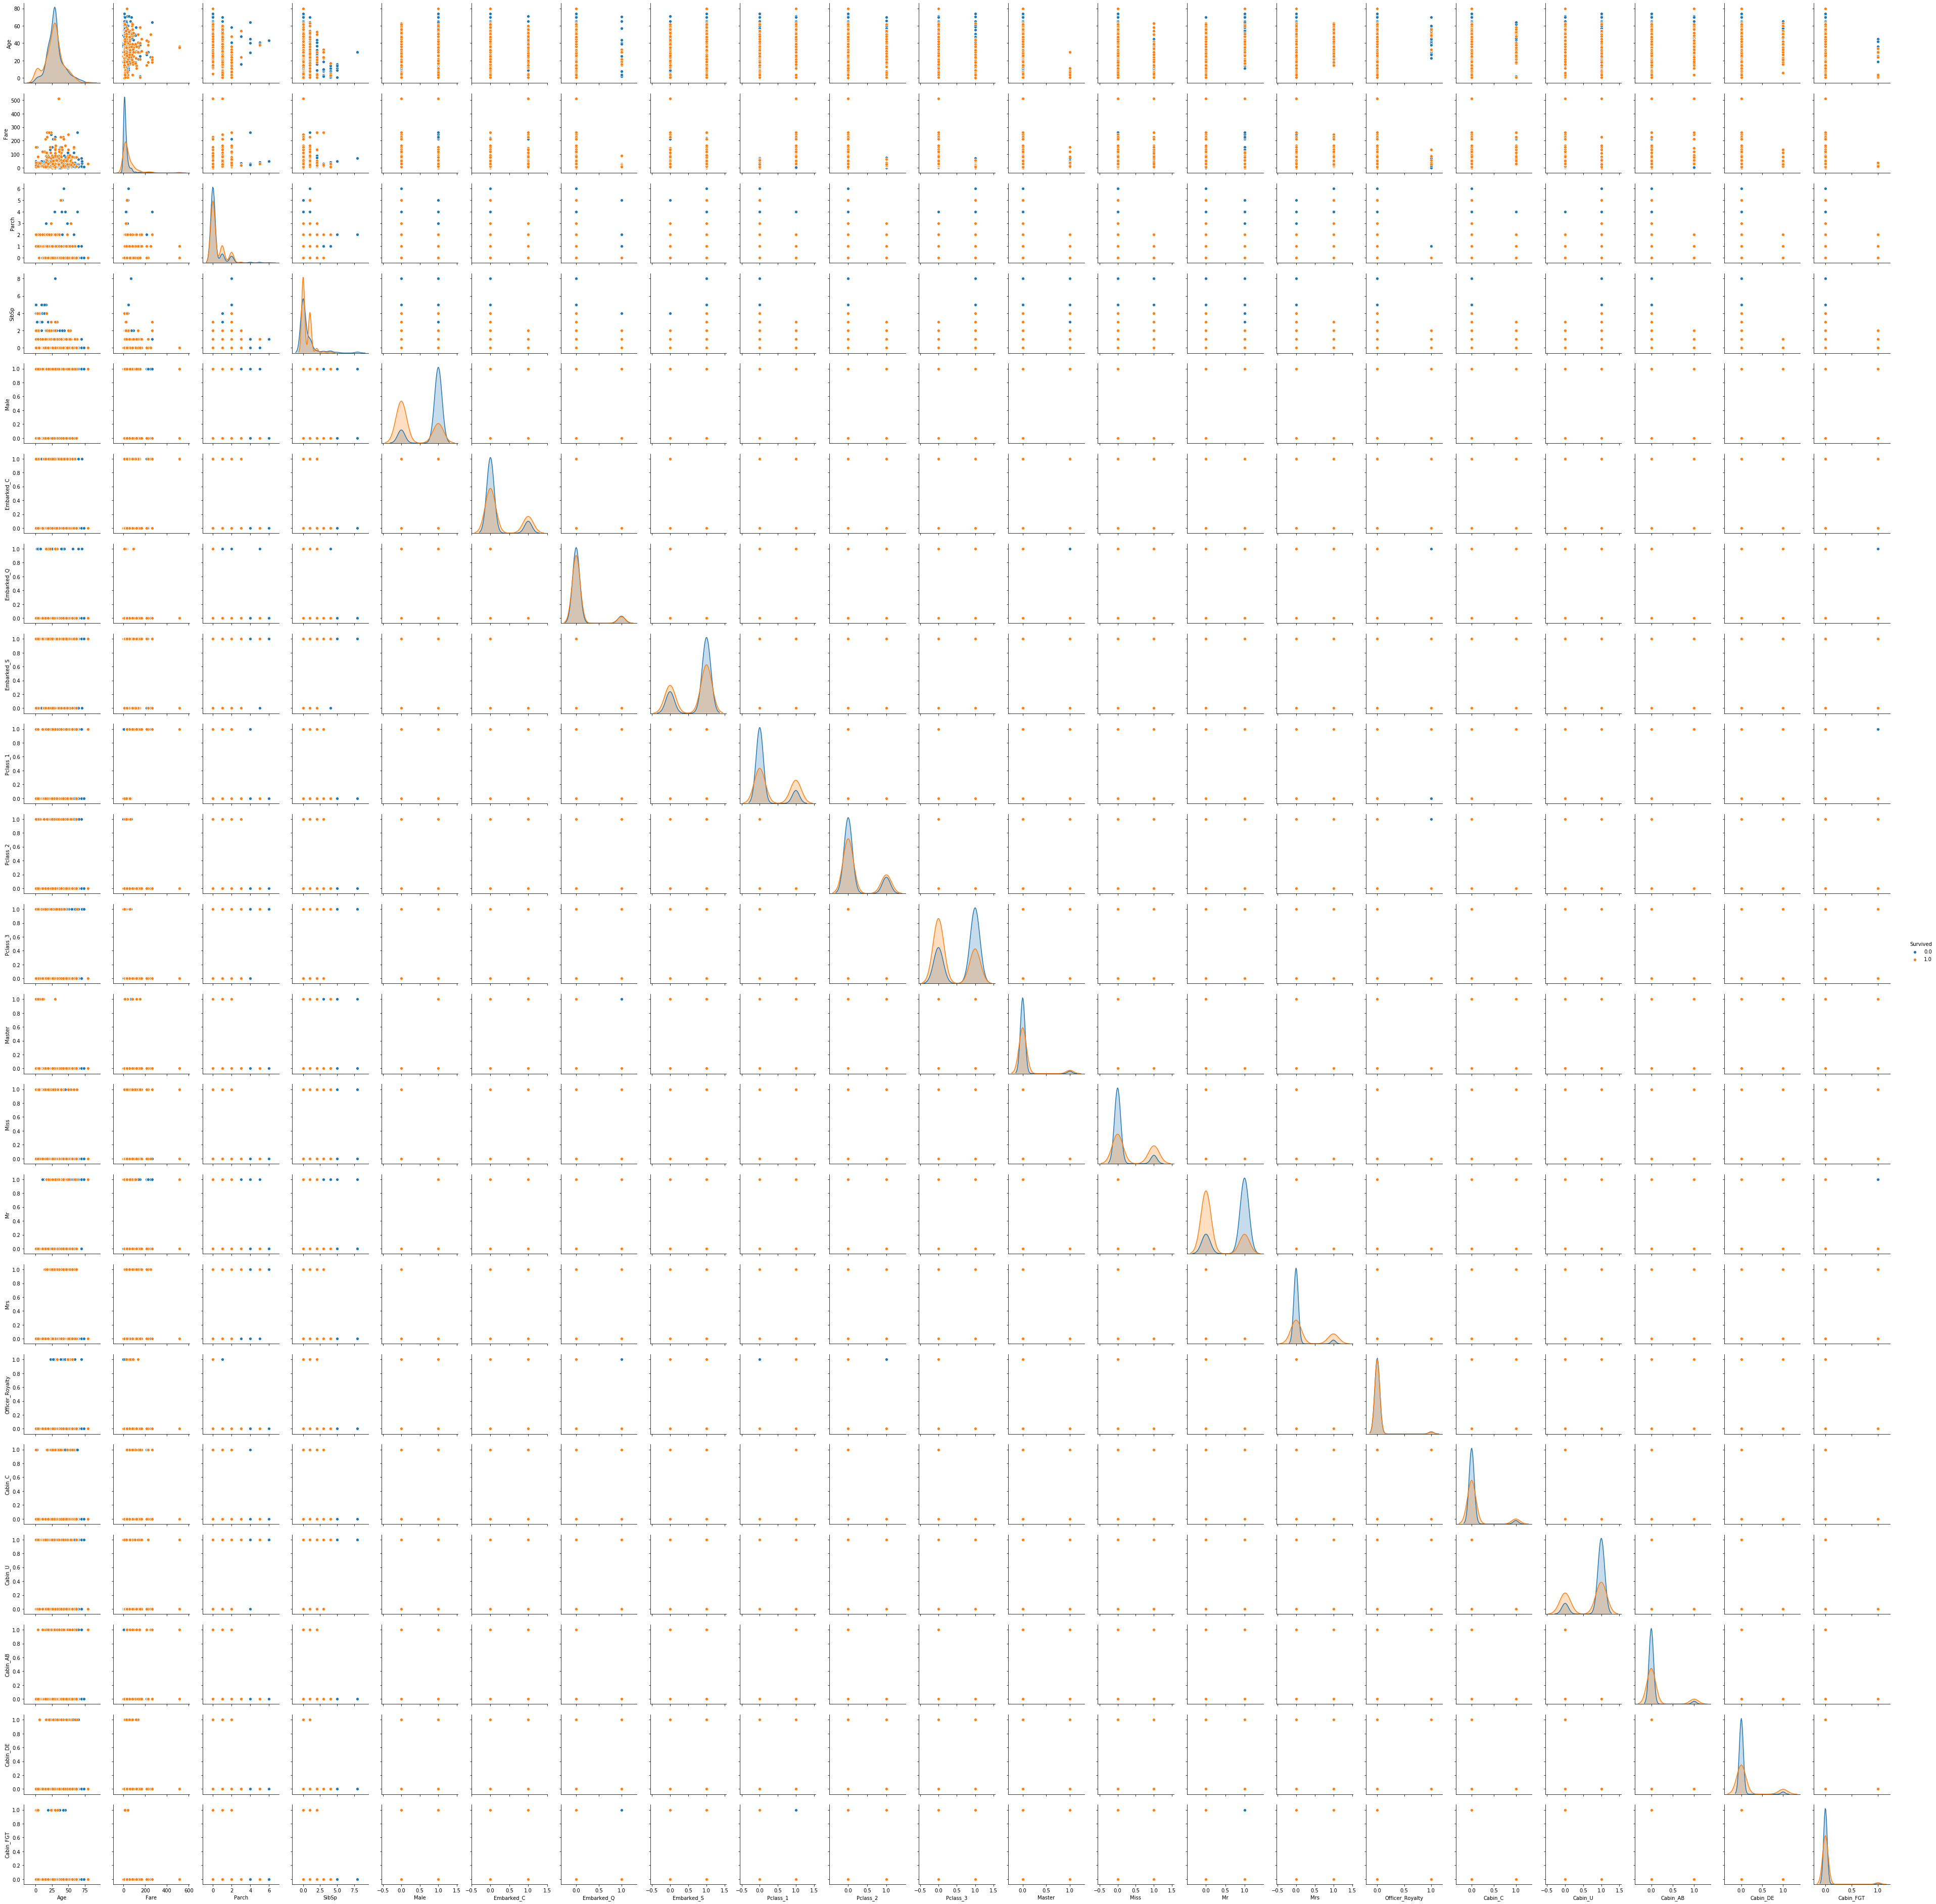

In [54]:
%%time
g = sns.pairplot(train,vars=train.columns[:-1], hue='Survived')#, palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.savefig("output.png")

In [ ]:
#A PARTIR DAQUI, COMEÇA O PROCESSO DE CLASSIFICAÇÃO!

#A partir apenas das amostras do arquivo train.csv, cria a base de treinamento e teste.
#X = full_X[0:train.shape[0]]
#y = titanic.Survived

#X_train, X_test, y_train, y_test = train_test_split(X , y, train_size = .8)

#clf = tree.DecisionTreeClassifier(criterion='gini')
#clf = clf.fit(X_train, y_train)
#preditor = clf.predict(X_test)